In [21]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import cv2
from PIL import Image
import tensorflow.keras.layers as l
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.utils.layer_utils import count_params


In [22]:
# # netword arctecture
# U-net
# motivation:detcting potholes need good spatial infromation with best achived by u-net

# hyper parameters
GENERATE_MASKS = False
FILTERS=64
ACTIVATION='relu'
INITIALIZER='he_uniform'
BIAS=True
LEARNING_RATE = 1e-4
INPUT_SHAPE = (256, 256, 3)
DROPOUT = 0.1
PRETRAINED = True
# depth: 4
# total parameter: 13949762


# # metrics
# accuracy
# dice loss
# data set: pothole_segmentation_yolov8 
# note: though it was picked for yolo as an Engineer my pleasure is in doint something well with something it wasn't supposed to be used for
# and of course some computational constrains
# training set: 720
# validation set: 60


In [23]:
def define_paths(base:str, routes:list[str]):
    return [base + route + "/" for route in routes]

def show_images(images, titles=None, cols=2, figsize=(15, 15)):
    """
    Displays a list of images using matplotlib.

    Parameters:
        images (list): List of image file paths or PIL Image objects.
        titles (list): List of titles for each image (optional).
        cols (int): Number of columns in the display grid.
        figsize (tuple): Size of the figure.
    """
    if titles is None:
        titles = [''] * len(images)
        
    n_images = len(images)
    rows = (n_images + cols - 1) // cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()  # Flatten the 2D array of axes into a 1D array

    for i, (img, title) in enumerate(zip(images, titles)):
        if isinstance(img, str):
            img = Image.open(img)  # Open image if a file path is provided
        axes[i].imshow(img)
        axes[i].set_title


def maskGenerator(img_dir, label_dir, mask_dir):
  if not os.path.exists(mask_dir):
    os.makedirs(mask_dir, exist_ok=True)

  img_list = os.listdir(img_dir)
  label_list = os.listdir(label_dir)

  for i in range(len(img_list)):
    img_name = img_list[i]
    label_name = '.'.join(img_name.split('.')[:-1]) + '.txt'
    if label_name not in label_list:
      print(label_name)
      pass

    img = cv2.imread(img_dir + img_name)
    label = label_dir + label_name
    img_shape = img.shape
    mask = np.zeros(img_shape)

    file1 = open(label, 'r')
    while True:
      poly = file1.readline()
      if not poly:
        break
      s = poly.split()
      #only single class of segmentation so we dont care about classes
      coord = np.array(s[1:], dtype='float32').reshape(-1,2)
      coord[:,0] = coord[:,0]*np.array(img_shape[0])
      coord[:,1] = coord[:,1]*img_shape[1]
      coord = coord.astype('int32')

      cv2.fillPoly(mask, pts = [coord], color =(255,255,255))
    cv2.imwrite(mask_dir + img_list[i], mask)


def make_pair(IMG_DIR,MASK_DIR=''):
  img_list = sorted(os.listdir(IMG_DIR))
  pairs = []
  if MASK_DIR!='':
    mask_list = sorted(os.listdir(MASK_DIR))

    for i in range(len(img_list)):
      img = IMG_DIR+img_list[i]
      mask = MASK_DIR+mask_list[i]
      pairs.append((img,mask))
  else:
    for i in range(len(img_list)):
      img = IMG_DIR+img_list[i]
      pairs.append((img,''))

  return pairs

class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, pair, batch_size=16, dim=(256,256,3), shuffle=True):
    self.dim = dim
    self.pair = pair
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.on_epoch_end()

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.pair))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __len__(self):
    return int(np.floor(len(self.pair) / self.batch_size))

  def generate_data(self, img_pos):
    img_batch = list()
    mask_batch = list()

    for i in img_pos:
      img = cv2.cvtColor(cv2.imread(self.pair[i][0]),cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, (self.dim[0],self.dim[1]))
      if self.pair[i][1]!='':
        mask = cv2.cvtColor(cv2.imread(self.pair[i][1]),cv2.COLOR_BGR2GRAY)
      else:
        mask = np.zeros(img.shape[:-1])
      mask = cv2.resize(mask, (self.dim[0],self.dim[1]))
      img = img.astype('float32')/255.0
      mask = mask.astype('float32')/255.0
      img_batch.append(img)
      mask_batch.append(mask)

    return np.array(img_batch), np.array(mask_batch)

  def __getitem__(self, index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    img_pos = [i for i in indexes]
    X, y = self.generate_data(img_pos)
    return X, y

def train_test_split(data:list, split:float):
    pivot = int(len(data) * split)
    return data[:pivot], data[pivot:]

def apply_mask(img_pot, mask_pot):
  img = img_pot
  img[:,:,1] = cv2.bitwise_or(img_pot[:,:,1], mask_pot)
  return img


def dice_loss(y_true, y_pred, smooth=1):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

    return 1 - dice

In [24]:
class ActivationLayer(l.Layer):
    def __init__(self, activation):
        super(ActivationLayer, self).__init__()

        if activation == 'leakyrelu':
            self.layer = l.LeakyReLU(alpha=0.01)
        elif activation == 'prelu':
            self.layer = l.PReLU()
        else:
            self.layer = l.Activation(activation)

    def call(self, t):
        return self.layer(t)

class ConvBlock(tf.keras.Model):
    def __init__(self, filters, activation, initializer, bias):
        super(ConvBlock, self).__init__()

        self.conv1 = l.Conv2D(filters=filters,
                              kernel_size=3,
                              padding='same',
                              kernel_initializer=initializer,
                              use_bias=bias)
        self.bn1 = l.BatchNormalization()
        self.act1 = ActivationLayer(activation=activation)

        self.conv2 = l.Conv2D(filters=filters,
                              kernel_size=3,
                              padding='same',
                              kernel_initializer=initializer,
                              use_bias=bias)
        self.act2 = ActivationLayer(activation=activation)
        self.bn2 = l.BatchNormalization()

    def call(self, t):
        t = self.conv1(t)
        t = self.bn1(t)
        t = self.act1(t)
        t = self.conv2(t)
        t = self.bn2(t)
        t = self.act2(t)

        return t

class UNet(tf.keras.Model):
    def __init__(self, filters, activation, initializer, bias, dropout=0.5):
        super(UNet, self).__init__()

        self.conv1 = ConvBlock(filters=filters,
                               activation=activation,
                               initializer=initializer,
                               bias=bias)
        self.conv2 = ConvBlock(filters=filters*2,
                               activation=activation,
                               initializer=initializer,
                               bias=bias)
        self.conv3 = ConvBlock(filters=filters*4,
                               activation=activation,
                               initializer=initializer,
                               bias=bias)
        self.conv4 = ConvBlock(filters=filters*8,
                               activation=activation,
                               initializer=initializer,
                               bias=bias)
        self.conv5 = ConvBlock(filters=filters*16,
                               activation=activation,
                               initializer=initializer,
                               bias=bias)

        self.convt1 = l.Conv2DTranspose(filters=filters*8,
                                        kernel_size=3,
                                        padding='same',
                                        strides=2,
                                        use_bias=bias,
                                        kernel_initializer=initializer)
        self.conv6 = ConvBlock(filters=filters*8,
                               activation=activation,
                                initializer=initializer,
                                bias=bias)

        self.convt2 = l.Conv2DTranspose(filters=filters*4,
                                        kernel_size=3,
                                        padding='same',
                                        strides=2,
                                        use_bias=bias,
                                        kernel_initializer=initializer)
        self.conv7 = ConvBlock(filters=filters*4,
                               activation=activation,
                                initializer=initializer,
                                bias=bias)

        self.convt3 = l.Conv2DTranspose(filters=filters*2,
                                        kernel_size=3,
                                        padding='same',
                                        strides=2,
                                        use_bias=bias,
                                        kernel_initializer=initializer)
        self.conv8 = ConvBlock(filters=filters*2,
                               activation=activation,
                                initializer=initializer,
                                bias=bias)

        self.convt4 = l.Conv2DTranspose(filters=filters,
                                        kernel_size=3,
                                        padding='same',
                                        strides=2,
                                        use_bias=bias,
                                        kernel_initializer=initializer)
        self.conv9 = ConvBlock(filters=filters,
                               activation=activation,
                                initializer=initializer,
                                bias=bias)

        self.conv10 = l.Conv2D(filters=2,
                               kernel_size=1,
                               use_bias=bias,
                               activation="sigmoid",
                               padding='same',
                               kernel_initializer=initializer)

        self.dropout = l.Dropout(dropout)

    def call(self, t):
        t = self.conv2(t)

        t1 = l.MaxPooling2D()(t)
        t1 = self.dropout(t1)
        t1 = self.conv3(t1)

        t2 = l.MaxPooling2D()(t1)
        t2 = self.dropout(t2)
        t2 = self.conv4(t2)

        t3 = l.MaxPooling2D()(t2)
        t3 = self.dropout(t3)
        t3 = self.conv6(t3)

        # # # # # # # # # #

        t4 = self.convt2(t3)
        t4 = l.Concatenate()([t4, t2])
        t4 = self.dropout(t4)
        t4 = self.conv7(t4)

        t4 = self.convt3(t4)
        t4 = l.Concatenate()([t4, t1])
        t4 = self.dropout(t4)
        t4 = self.conv8(t4)

        t4 = self.convt4(t4)
        t4 = l.Concatenate()([t4, t])
        t4 = self.dropout(t4)
        t4 = self.conv9(t4)

        t = self.conv10(t4)
        
        return t

In [25]:
def create_model(filters, activation, initializer, bias, learning_rate, input_shape, dropout):
    with tf.device('/gpu:0'):
        input_layer = tf.keras.Input(shape=input_shape)
        out = UNet(filters, activation, initializer, bias, dropout)(input_layer)

        optim = Adam(learning_rate=learning_rate)
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        model = tf.keras.Model(inputs=input_layer, outputs=out)
        model.compile(optimizer=optim, loss=loss_fn, metrics=['accuracy', dice_loss])
        print(f'total parameter: {count_params(model.trainable_weights)}')

        return model

def train_model(model, name, data_generator, test_generator, epochs):
    print(f'train {name}')

    history = model.fit(data_generator,
                        epochs=epochs,
                        validation_data=test_generator,
                        )

    model.save(f'weight_{name}.h5')
    np.save(f'history_{name}.npy',history.history)

In [26]:
train_images_path, train_labels_path = define_paths(
        "./pothole-image-segmentation-dataset/Pothole_Segmentation_YOLOv8/train/",
        ["images", "labels"]
    )

train_masks_path = define_paths(
        "./pothole-image-segmentation-dataset/Pothole_Segmentation_YOLOv8/",
        ["train/masks"]
    )[0]

valid_images_path, valid_labels_path = define_paths(
        "./pothole-image-segmentation-dataset/Pothole_Segmentation_YOLOv8/valid/",
        ["images", "labels"]
    )

valid_masks_path = define_paths(
        "./pothole-image-segmentation-dataset/Pothole_Segmentation_YOLOv8/",
        ["valid/masks"]
    )[0]

In [27]:
if GENERATE_MASKS:
  maskGenerator(train_images_path, train_labels_path, train_masks_path)
  maskGenerator(valid_images_path, valid_labels_path, valid_masks_path)

In [28]:
pairs = make_pair(train_images_path, train_masks_path)
random.shuffle(pairs)
train_pairs, test_pairs = train_test_split(pairs, 0.8)
test_generator = DataGenerator(pair = test_pairs, dim=(256,256,3), shuffle=True)
train_generator = DataGenerator(pair = train_pairs, batch_size=16, dim=(256,256,3), shuffle=True)

In [29]:
model = create_model(FILTERS, ACTIVATION, INITIALIZER, BIAS, LEARNING_RATE, INPUT_SHAPE, DROPOUT)

C:\Users\basil alajlouney\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\layer.py:357: UserWarning: `build()` was called on layer 'u_net_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


total parameter: 13949762


1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step


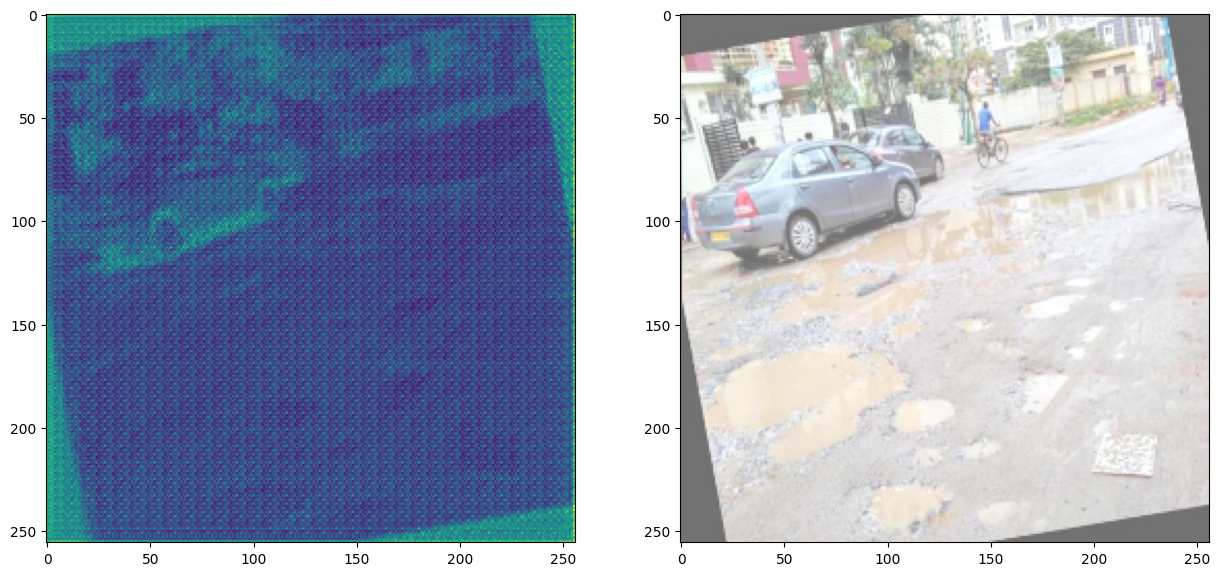

In [30]:
names = os.listdir("./pothole-image-segmentation-dataset/Pothole_Segmentation_YOLOv8/train/images")
i = np.random.randint(0,60)
imgTest = cv2.cvtColor(cv2.imread('./pothole-image-segmentation-dataset/Pothole_Segmentation_YOLOv8/train/images/' + names[i]), cv2.COLOR_BGR2RGB)
imgTest = cv2.resize(imgTest,(256,256)).astype('float32') / 255.0
imgTest = np.array([imgTest])
pred_mask = model.predict(imgTest)
show_images([pred_mask[0][:,:,0], imgTest[0]])

In [31]:
if not PRETRAINED:
  train_model(model, 'pothole_unet', train_generator, 1)
else:
  model.load_weights("./weight_pothole_unet.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


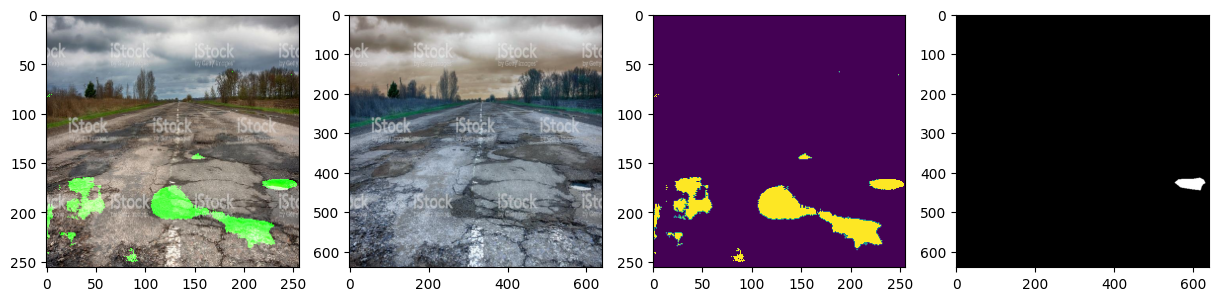

In [33]:
base_dir = "./pothole-image-segmentation-dataset/Pothole_Segmentation_YOLOv8/valid/"
names = sorted(os.listdir(base_dir + "images"))

# i = np.random.randint(0,60) # 44
i = 44
img_path = base_dir + "images/" +names[i]
mask_path = base_dir + "masks/" +names[i]
img = cv2.imread(img_path)
mask = cv2.imread(mask_path)

imgTest = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
imgTest = cv2.resize(imgTest,(256,256)).astype('float32')/255.0
imgTest = np.array([imgTest])

pred_mask = model.predict(imgTest)
predicted_mask = (pred_mask[0, :,:,1] > .5).astype(np.float32)
masked_iamge = apply_mask(imgTest[0], predicted_mask)
show_images([masked_iamge, img, predicted_mask, mask], cols=4)